**1. Entropy-Complexity Plane. Task here is to distinguish between chaotic and regular time series data.**

In [26]:
import numpy as np
import math
import itertools
import matplotlib.pyplot as plt
import warnings
!pip install DBSCAN1D

from tqdm import tqdm
from scipy.spatial import distance
from sklearn.cluster import DBSCAN
from dbscan1d.core import DBSCAN1D

In [27]:
!wget https://raw.githubusercontent.com/mlkyai/TS/main/lorenz.txt

--2023-12-23 20:47:08--  https://raw.githubusercontent.com/mlkyai/TS/main/lorenz.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2500025 (2.4M) [text/plain]
Saving to: ‘lorenz.txt.3’

lorenz.txt.3        100%[===================>]   2.38M  --.-KB/s    in 0.01s   

2023-12-23 20:47:08 (159 MB/s) - ‘lorenz.txt.3’ saved [2500025/2500025]



In [28]:
!ls

lorenz.txt  lorenz.txt.1  lorenz.txt.2	lorenz.txt.3  sample_data


In [29]:
# Skew tent map
def skew_tent_map(n=2**15, omega=0.1847, x0=.5):
    x = np.zeros(n)
    x[0] = x0
    for i in range(1, len(x)):
        if x[i-1] < omega:
            x[i] = x[i-1]/omega
        else:
            x[i] = (1-x[i-1])/(1-omega)
    return x

In [30]:
# Logistic map
def logistic_map(n=2**15, r=4, x0=.4):
    x = np.zeros(n)
    x[0] = x0
    for i in range(n-1):
        x[i+1] = r*x[i]*(1-x[i])
    return x

In [31]:
# Schuster's map
def schuster_map(n=2**15, z=2, x0=.5):
    z = float(z)
    x = np.zeros(n)
    x[0] = x0
    for i in range(1, n):
        x[i], _ = np.modf(x[i-1] + x[i-1]**z)
    return x

In [32]:
# Henon map
def henon_map(n=1000000, a=1.4, b=0.3, x0=.4):
    x = np.zeros(n)
    x[0] = x0
    for i in range(1, len(x)):
        x[i] = 1 - a * x[i-1] ** 2 + b * x[i-1]
    return x

### Sine Dataset (Deterministic)

In [33]:
# Sine Dataset (Deterministic)
sine_data = np.sin(np.arange(0,1000,.01))

### Gaussian Noise (Stochastic)

In [34]:
# Gaussian Noise (Stochastic)
gaussian_noise = np.random.normal(size=100000)

In [35]:
def chunks(time_series, s):

    # number of all possible chunks
    num_chunks = len(time_series) - s + 1
    chunks = np.zeros((num_chunks, s))
    for i in range(num_chunks):
      chunks[i] = time_series[i:i+s]
    return chunks

**function for probability distribution,it calculates the frequency of each unique pattern in the chunks and returns a probability distribution based on the counts:**

In [36]:
def calculate_probability_distribution(chunks, permutations):

    # mapping from permutation tuples to their indices
    permutation_indices = {perm: i for i, perm in enumerate(permutations)}

    # an array of zeros with the length of permutations
    distribution = np.zeros(len(permutations))

    #the sorted indices
    sorted_chunks = np.argsort(chunks, axis=1)

    # occurrences of each unique pattern
    for pattern in sorted_chunks:
        pattern_tuple = tuple(pattern)
        if pattern_tuple in permutation_indices:
            distribution[permutation_indices[pattern_tuple]] += 1

    # Normalized distribution
    distribution /= distribution.sum()

    return distribution

**Function for Shannon entropy, iterates over elemnts of a probability distribution and computesentropy contribution of each valid value. Higher values indicates greater uncertainty:**

**P** - probability distribution

In [37]:
def shannon_entropy(probabilities):

    # non-positive probability values
    positive_probs = probabilities[probabilities > 0]

    # vectorized entropy calculation
    sh_entropy = -np.sum(positive_probs * np.log(positive_probs))

    return sh_entropy

**Divergence measure between input probability distribution and uniform distribution:**  



 **N** - total number of patterns

In [38]:
def qj_divergence(N, P):

    # the constant Q0
    Q0 = -2 / (((N + 1) / N) * np.log(N + 1) - 2 * np.log(2 * N) + np.log(N))

    # equal probabilities array
    Pe = np.full_like(P, 1 / N)

    # divergence using Shannon entropy
    average_Pe_P = (P + Pe) / 2
    entropy_average = -np.sum(average_Pe_P[average_Pe_P > 0] * np.log(average_Pe_P[average_Pe_P > 0]))
    entropy_P = -np.sum(P[P > 0] * np.log(P[P > 0]))
    Qj = Q0 * (entropy_average - entropy_P / 2 - np.log(N) / 2)

    return Qj

**Function for Entropy Complexity:**
- **Hs** - normalized entropy measure
- **Cjs** - complexity measure combining entropy and divergence
- **d** - parameter for chunking the TS
- **permutations** -  list of permutations of patterns

In [39]:
def entropy_complexity(time_series, d, permutations):
    # probability distribution of TS
    chunk_list = chunks(time_series, d)
    probability_distribution = calculate_probability_distribution(chunk_list, permutations)

    # Shannon entropy.
    shannon_entropy = -np.sum(probability_distribution[probability_distribution > 0] *
                              np.log(probability_distribution[probability_distribution > 0]))

    # maximum possible entropy
    max_entropy = np.log(len(probability_distribution))

    # normalized entropy 'Hs'
    normalized_entropy = shannon_entropy / max_entropy

    # complexity measure 'Cjs'.
    complexity_measure = qj_divergence(probability_distribution.size, probability_distribution) * normalized_entropy

    return normalized_entropy, complexity_measure

**Behavior of entropy and complexity measures for different distributions obtained by varying a step parameter:**

In [40]:
def min_complexity():

    # total number of elements in distribution
    N = 1000

    # an array of step parameters
    steps = np.arange(0.005, 1.005, 0.005)

    entropy = np.zeros_like(steps)
    complexity = np.zeros_like(steps)

    for idx, step in enumerate(steps):
        distribution = np.full(N, (1 - step) / (N - 1))
        distribution[0] = step
        entropy[idx] = shannon_entropy(distribution) / np.log(N)
        complexity[idx] = qj_divergence(N, distribution) * entropy[idx]

    return entropy, complexity

**function shows behavior of entropy and complexity measures for different distributions based on the value of 'd':**

In [41]:
def max_complexity(d):
    # total number of permutations
    N = math.factorial(d)

    entropy = []
    complexity = []

    for i in range(N - 1):
        # steps for the distribution
        steps = np.linspace(0, 1 / (N - i), int((1 - 1 / N) * 100) + 1)[:-1]
        for step in steps:
            distribution = np.full(N, (1 - step) / (N - i - 1))
            distribution[0] = step
            if i > 0:
                distribution[-i:] = 0

            # normalized Shannon entropy
            current_entropy = shannon_entropy(distribution) / np.log(N)
            entropy.append(current_entropy)

            # Complexity
            current_complexity = qj_divergence(N, distribution) * current_entropy
            complexity.append(current_complexity)

    return np.array(entropy), np.array(complexity)

**the entropy and complexity for both minimum and maximum cases:**

In [42]:
# value of number of elements
d = 6

# list of all integer permutations
permutations = list(itertools.permutations(range(d)))

# minimum entropy and complexity for a range of distributions
x_min, y_min = min_complexity()

# maximum_entropy_complexity
x_max, y_max = max_complexity(d)

In [43]:
# File path for the data file
file_path = "lorenz.txt"

# convertion of file to an array
lorenz_TS = np.loadtxt(file_path)

# Take the first 10000 elements from the series
lorenz_data = lorenz_TS[:10000]


**calculations and analyses on different time series data, including chaotic maps and sine wave data, Gaussian noise data, Lorenz TS data by computing their entropy and complexity measures:**

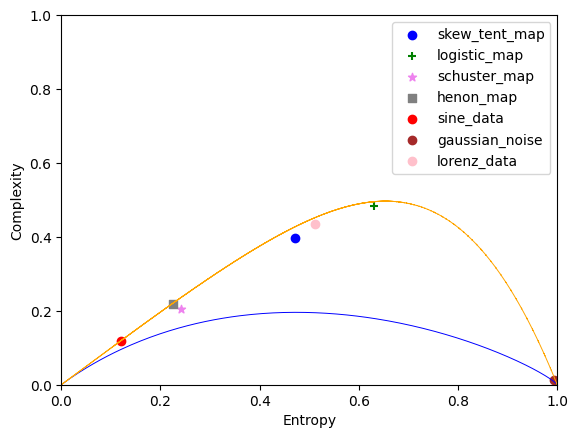

In [44]:
# Maps and their corresponding functions
maps = {
    "skew_tent_map": skew_tent_map,
    "logistic_map": logistic_map,
    "schuster_map": schuster_map,
    "henon_map": henon_map,
    "sine_data": lambda: sine_data,
    "gaussian_noise": lambda: gaussian_noise,
    "lorenz_data": lambda: lorenz_data
}

# dictionaries for entropy and complexity values
Hs_values = {}
Cjs_values = {}

# entropy and complexity for each map
for map_name, map_func in maps.items():
    time_series = map_func()[:10000]
    Hs, Cjs = entropy_complexity(time_series, d, permutations)
    Hs_values[map_name] = Hs
    Cjs_values[map_name] = Cjs

# Scatter plot for entropy vs complexity
plt.plot(x_min, y_min, c='blue', linewidth=0.7)
plt.plot(x_max, y_max, c='orange', linewidth=0.7)

# Colors and markers for different maps
colors_markers = {
    "skew_tent_map": ('blue', 'o'),
    "logistic_map": ('green', '+'),
    "schuster_map": ('violet', '*'),
    "henon_map": ('gray', 's'),
    "sine_data": ('red', 'o'),
    "gaussian_noise": ('brown', 'o'),
    "lorenz_data": ('pink', 'o')
}

# scatter plots for each map
for map_name, (color, marker) in colors_markers.items():
    plt.scatter(Hs_values[map_name], Cjs_values[map_name], label=map_name, c=color, marker=marker)

plt.xlim(0, 1)
plt.ylim(0, 1)
plt.xlabel('Entropy')
plt.ylabel('Complexity')
plt.legend()
plt.show()


**Analysis:**

Sine function and Gaussian noise have low complexity scores. The reason -  their predictable and random natures. Chaotic maps are spread across the plot, each showing unique entropy-complexity relationships. It indicates diverse behaviors within chaotic systems.
Gaussian noise has a high entropy score, aligning with expected high unpredictability of noise.
Lorenz TS data points are on opposite ends of complexity scale. It indicates different regimes and parameters within the Lorenz system that exhibit different characteristics.
Relationship between entropy and complexity is not linear and simple. Different systems exhibit high complexity with varying levels of entropy, and vice versa. This visualization is particularly useful in studying dynamical systems, chaos theory, and information theory. It helps to categorize systems according to their behavioral characteristics.